# Part 03: Using Finetuned Prithvi model for Inference

## What is Inferencing?

According to [NVIDIA](https://developer.nvidia.com/topics/ai/ai-inference), Inference (Machine Learning / AI) *"is the process of generating outputs from a model by providing it inputs. There are numerous types of data inputs and outputs—such as images, text, or video—that are used to produce applications such as a weather forecast or a conversation with a large language model (LLM)."*

For our specific use case, Inferencing is the part where we use the finetuned Prithvi model to predict Land Use classes based on the 6 classes we used for training. To recap, the 6 classes that we have are:

| Land Use | Raster Value | Color Code |
|----------|----|----|
| Urban | 1 | red |
| Agricultural | 2 | yellow |
| Forest | 3 | green |
| Water | 4 | blue |
| Oil Palm | 5 | purple |
| Para Rubber | 6 | pink |

## Running the Inference scripts

### Prerequisites

Before running the inferencing, you need to have:

1. Pre-trained or Finetuned Prithvi model
2. Target dataset (HLS / Landsat / Sentinel) with 18 bands (6 bands x 3 time periods).

### Inference Scripts

#### Visualizing Target datasets

For this part, we prepared two sample images:
1. Bangkok
2. Ubon Ratchathani

NOTE: These two images are mosaics of multiple HLS images and might contain some blank regions.


Image shape: (18, 3660, 3660)


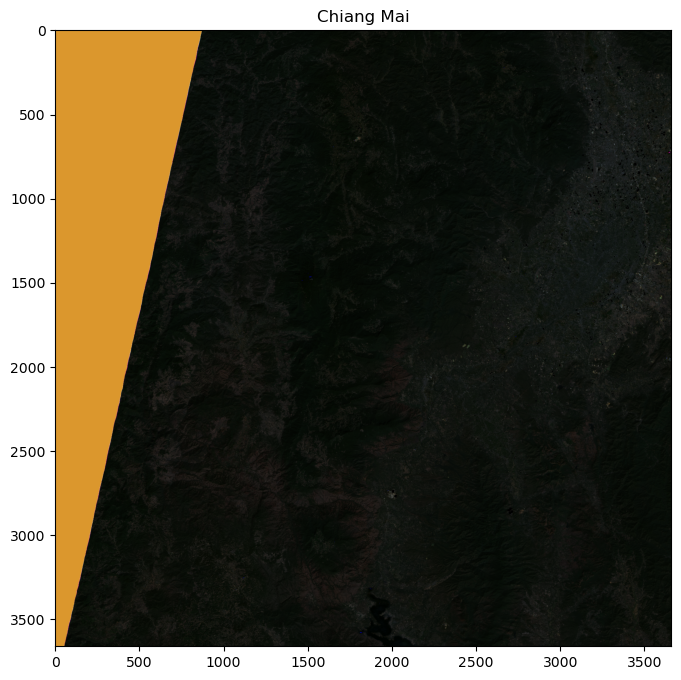


Image shape: (18, 3660, 3660)


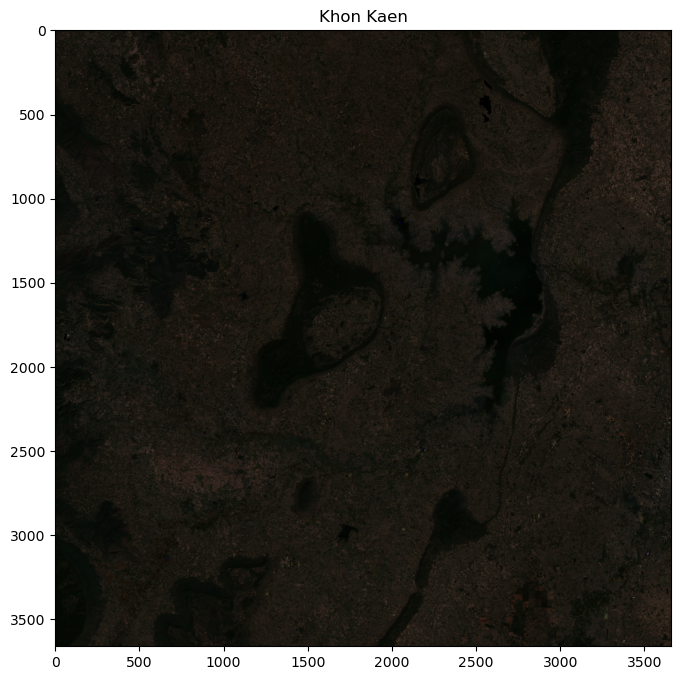


Image shape: (18, 3660, 3660)


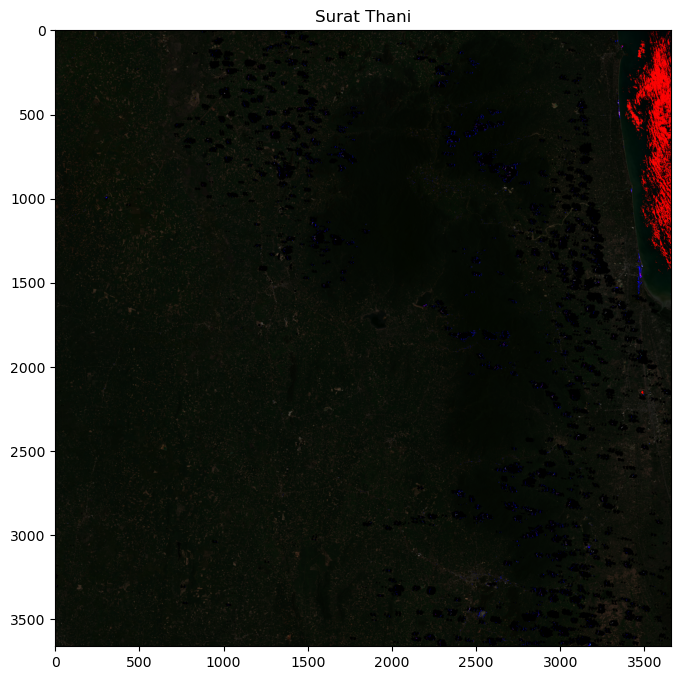

CPU times: user 3.9 s, sys: 745 ms, total: 4.64 s
Wall time: 6.29 s


In [7]:
%%time
# Visualizing Bangkok and Ubon-Ratchathani
# ESTIMATED RUNTIME: <1 minute, if the cell runs for more than 1min, restart the kernel

import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

## Visualizing the sample rasters
cm_path = "/home/jovyan/shared/Sirinya/Prithvi/output_CM/chiang_mai_HLS_18bands.tif"
kk_path = "/home/jovyan/shared/Arissara/Prithvi/output/knon-kaen_HLS_18bands.tif"
st_path = "/home/jovyan/shared/PCN/Prithvi/output/surat_thani_HLS_18bands.tif"

def visualize_raster(raster_path,name):
    with rio.open(raster_path) as src:
        data = src.read()
        print("\nImage shape:",data.shape) #check if the target images has 18bands

        # visualize the HLS file
        rgb = src.read([3,2,1]) # change to [3,2,1] for RGB. [4,3,2] shows False Color

        # scale to 0-255 for visualization
        scaled_rgb = np.zeros_like(rgb, dtype=np.uint8)

        for i in range(3):
            band = rgb[i]
            min_val = np.min(band[band > 0]) #
            max_val = np.max(band[band > 0]) # band > 0 will select pixel values that are positive
            scaled_rgb[i] =  ((band - min_val) / (max_val - min_val)*255).astype(np.uint8)

        scaled_rgb_new = scaled_rgb.transpose((1,2,0))

        # display the RGB image
        plt.figure(figsize=(8,8))
        plt.imshow(scaled_rgb_new)
        plt.title(name)
        plt.show()
        
# bangkok
visualize_raster(cm_path,"Chiang Mai")
visualize_raster(kk_path,"Khon Kaen")
visualize_raster(st_path,"Surat Thani")

#### Running the actual inferencing

IMPORTANT: Due to a relatively long code, the succeeding cells should be executed/run in sequence as we run the inference cell by cell.

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce GTX 1070 Ti


In [7]:
import torch
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))

CUDA Available: True
Device Name: NVIDIA GeForce GTX 1070


In [8]:
%%time
# ESTIMATED RUNTIME: <1 minute

import os
import glob
import time

import numpy as np
import rasterio
import torch
from mmcv import Config
from mmcv.parallel import collate, scatter
from mmseg.apis import init_segmentor
from mmseg.datasets.pipelines import Compose, LoadImageFromFile

## DEFINE PARAMETERS, change the paths as necessary
config_path = '/home/jovyan/shared/PCN/Prithvi/03_inference/finetuned_config.py' # path to model configuration file
#ckpt = '/home/jovyan/training_materials/data/03_inference/finetuned_prithvi.pth' # path to model checkpoint/.pth file
ckpt = '/home/jovyan/shared/PCN/Prithvi/03_inference/finetuned_prithvi.pth'
input_path = '/home/jovyan/shared/PCN/Prithvi/03_inference/target_datasets_2' # path to input images folder for inference
input_type = 'tif' #file type of input images
output_path = 'output/inference_outputs_2' #path to save output image
bands = None # bands in the file where to find the relevant data, type = int. Use only if there are specific bands in the target dataset where the data is
device = 'cuda' #default value is cuda, change accordingly

## ACTUAL INFERENCE
#### STEP 1: load the model
print("\n>>> Step 1: Loading the model <<<")
config = Config.fromfile(config_path)
config.model.backbone.pretrained = None
model = init_segmentor(config, ckpt, device)

#### STEP 2: locate the target images
print("\n>>> Step 2: Locate the target images <<<")
target_images = glob.glob(os.path.join(input_path, "*." + input_type))
print("No of target images:",len(target_images))

# check if output folder available
if not os.path.isdir(output_path):
    os.mkdir(output_path)
    
#### STEP 3: Test Pipeline
#NOTE:THIS IS ONLY FOR IMAGES THAT HAVE SPECIFIC TARGET BANDS
print("\n>>> Step 3: Modify the test pipeline if necessary <<<")

def process_test_pipeline(custom_test_pipeline, bands=None):
    # change extracted bands if necessary
    if bands is not None:
        extract_index = [
            i for i, x in enumerate(custom_test_pipeline) if x["type"] == "BandsExtract"
        ]

        if len(extract_index) > 0:
            custom_test_pipeline[extract_index[0]]["bands"] = bands

    collect_index = [
        i for i, x in enumerate(custom_test_pipeline) if x["type"].find("Collect") > -1
    ]

    # adapt collected keys if necessary
    if len(collect_index) > 0:
        keys = [
            "img_info",
            "filename",
            "ori_filename",
            "img",
            "img_shape",
            "ori_shape",
            "pad_shape",
            "scale_factor",
            "img_norm_cfg",
        ]
        custom_test_pipeline[collect_index[0]]["meta_keys"] = keys

    return custom_test_pipeline

# run the function
custom_test_pipeline = process_test_pipeline(model.cfg.data.test.pipeline, bands)


>>> Step 1: Loading the model <<<
load checkpoint from local path: /home/jovyan/shared/PCN/Prithvi/03_inference/finetuned_prithvi.pth

>>> Step 2: Locate the target images <<<
No of target images: 3

>>> Step 3: Modify the test pipeline if necessary <<<
CPU times: user 1.3 s, sys: 552 ms, total: 1.86 s
Wall time: 1.37 s


In [2]:
pip show mmcv

Note: you may need to restart the kernel to use updated packages.


In [9]:
%%time
# ESTIMATED RUNTIME: 6 - 15 minutes
# Some parts of the code are from the model_inference.py script available from the Prithvi github
# IMPORTANT: The larger the image for prediction, the more memory and CPU utilization is expected. Runtime also takes a lot longer

#### STEP 4: Iterate prediction for every output image
print("\n>>> Step 4: Iterate prediction for every output image <<<")

# define a function to open/read a tif file
def open_tiff(fname):
    with rasterio.open(fname, "r") as src:
        data = src.read()

    return data

# define a function to write a tif file
def write_tiff(img_wrt, filename, metadata):
    """
    It writes a raster image to file.

    :img_wrt: numpy array containing the data (can be 2D for single band or 3D for multiple bands)
    :filename: file path to the output file
    :metadata: metadata to use to write the raster to disk
    :return:
    """

    with rasterio.open(filename, "w", **metadata) as dest:
        if len(img_wrt.shape) == 2:
            img_wrt = img_wrt[None]

        for i in range(img_wrt.shape[0]):
            dest.write(img_wrt[i, :, :], i + 1)

    return filename

# define a function get the metadata of an image
def get_meta(fname):
    with rasterio.open(fname, "r") as src:
        meta = src.meta

    return meta

# define function to perform inference
def inference_segmentor(model, imgs, custom_test_pipeline=None):
    """Inference image(s) with the segmentor.

    Args:
        model (nn.Module): The loaded segmentor.
        imgs (str/ndarray or list[str/ndarray]): Either image files or loaded
            images.

    Returns:
        (list[Tensor]): The segmentation result.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    # build the data pipeline
    test_pipeline = (
        [LoadImageFromFile()] + cfg.data.test.pipeline[1:]
        if custom_test_pipeline == None
        else custom_test_pipeline
    )
    test_pipeline = Compose(test_pipeline)
    # prepare data
    data = []
    imgs = imgs if isinstance(imgs, list) else [imgs]
    for img in imgs:
        img_data = {"img_info": {"filename": img}}
        img_data = test_pipeline(img_data)
        data.append(img_data)
    # print(data.shape)

    data = collate(data, samples_per_gpu=len(imgs))
    if next(model.parameters()).is_cuda:
        # data = collate(data, samples_per_gpu=len(imgs))
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        # img_metas = scatter(data['img_metas'],'cpu')
        # data['img_metas'] = [i.data[0] for i in data['img_metas']]

        img_metas = data["img_metas"].data[0]
        img = data["img"]
        data = {"img": img, "img_metas": img_metas}

    with torch.no_grad():
        result = model(return_loss=False, rescale=True, **data)
    return result

# define function to perform inference on each target file
def inference_on_file(model, target_image, output_image, custom_test_pipeline):
    time_taken = -1
    try:
        st = time.time()
        print("Running inference...")
        result = inference_segmentor(model, target_image, custom_test_pipeline)
        print("Output has shape: " + str(result[0].shape))

        # get metadata mask
        mask = open_tiff(target_image)
        meta = get_meta(target_image)
        mask = np.where(mask == meta["nodata"], 1, 0)
        mask = np.max(mask, axis=0)[None]

        result[0] = np.where(mask == 1, -1, result[0])

        # sve file to disk
        meta["count"] = 1
        meta["dtype"] = "int16"
        meta["compress"] = "lzw"
        meta["nodata"] = -1
        print("Saving output...")
        write_tiff(result[0], output_image, meta)
        et = time.time()
        time_taken = np.round(et - st, 1)
        print(
            f"Inference completed in {str(time_taken)} seconds. Output available at: "
            + output_image
        )

    except:
        print(f"Error on image {target_image} \nContinue to next input")

    return time_taken

# for each image predict and save to disk
for i, target_image in enumerate(target_images):
    print("\n> Working on Image {} <".format(i+1))
    output_image = os.path.join(
        output_path,
        target_image.split("/")[-1].replace(
            "." + input_type, "_pred." + input_type
        ),
    )
    
    inference_on_file(model,
                      target_image,
                      output_image,
                      custom_test_pipeline)


>>> Step 4: Iterate prediction for every output image <<<

> Working on Image 1 <
Running inference...
Output has shape: (3660, 3660)
Saving output...
Inference completed in 338.5 seconds. Output available at: output/inference_outputs_2/chiang_mai_HLS_18bands_pred.tif

> Working on Image 2 <
Running inference...
Output has shape: (3660, 3660)
Saving output...
Inference completed in 338.9 seconds. Output available at: output/inference_outputs_2/knon-kaen_HLS_18bands_pred.tif

> Working on Image 3 <
Running inference...
Output has shape: (3660, 3660)
Saving output...
Inference completed in 339.4 seconds. Output available at: output/inference_outputs_2/surat_thani_HLS_18bands_pred.tif
CPU times: user 5min 27s, sys: 11min 34s, total: 17min 2s
Wall time: 16min 56s


#### Visualizing Outputs

Raster CRS: EPSG:32647


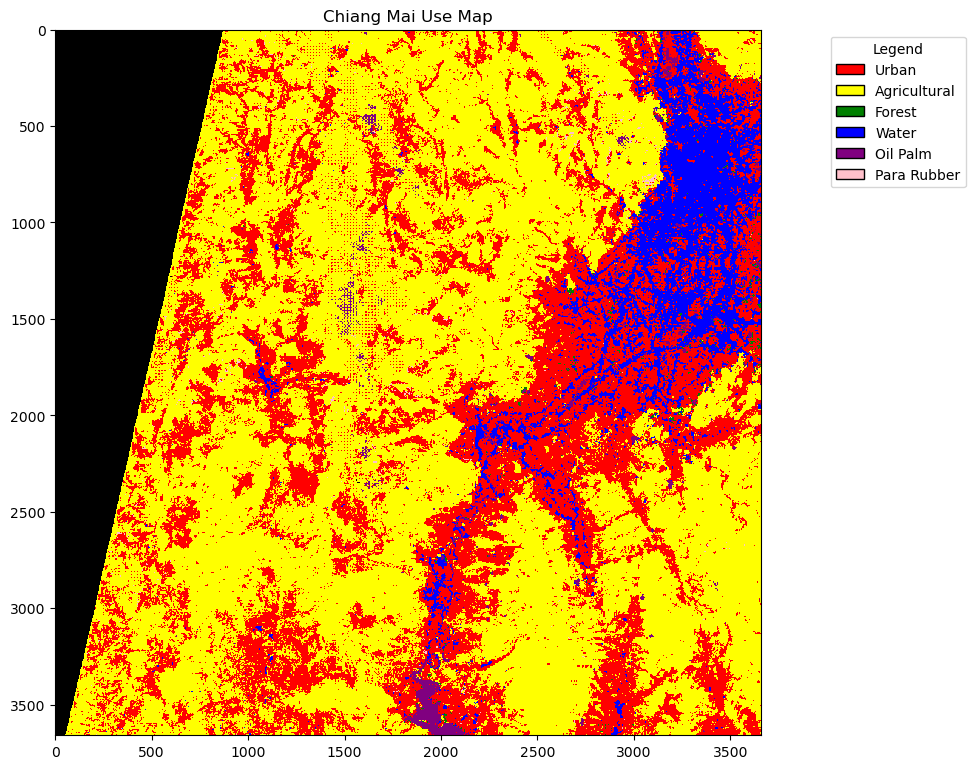

Raster CRS: EPSG:32647


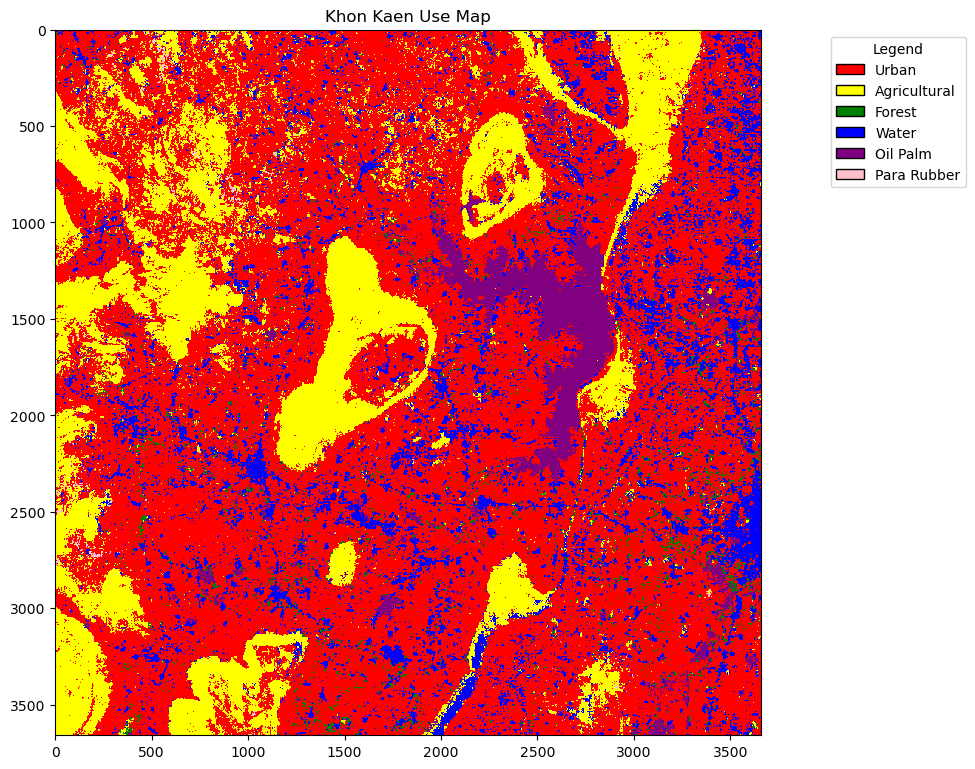

Raster CRS: EPSG:32647


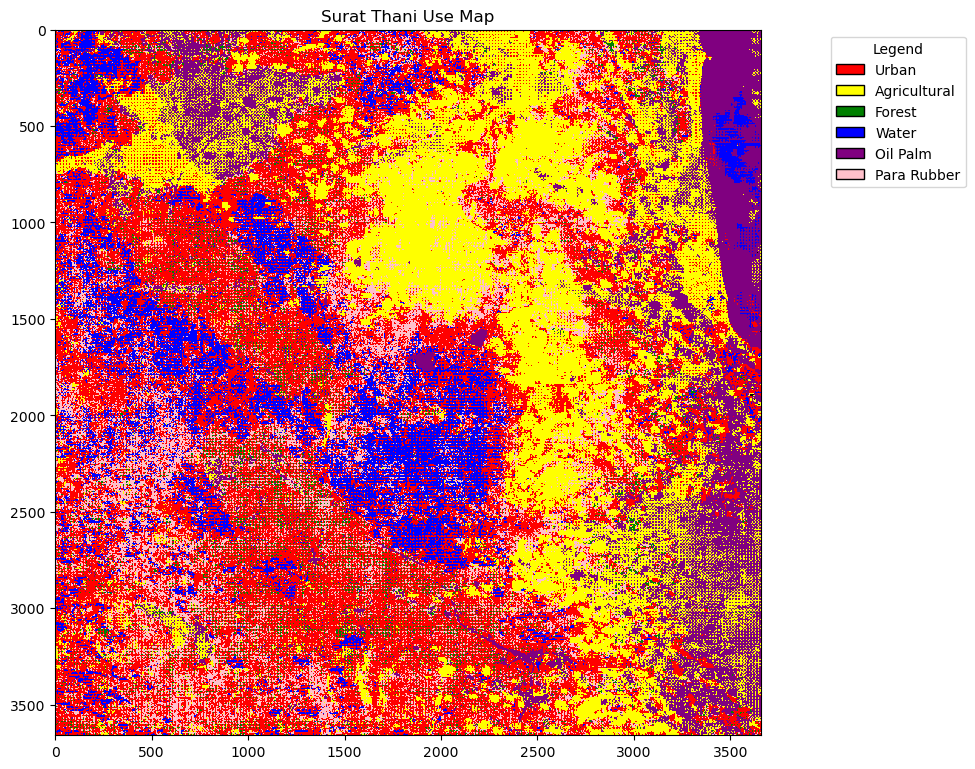

CPU times: user 1.02 s, sys: 531 ms, total: 1.55 s
Wall time: 966 ms


In [10]:
%%time
## Visualizing outputs for Bangkok and Ubon-Ratchathani
import os
import rasterio as rio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


# Step 1: read the raster file
# IMPORTANT: Make sure that the paths contain the output inference images
cm_outpath = "/home/jovyan/shared/PCN/Prithvi/output/inference_outputs_2/chiang_mai_HLS_18bands_pred.tif"
kk_outpath = "/home/jovyan/shared/PCN/Prithvi/output/inference_outputs_2/knon-kaen_HLS_18bands_pred.tif"
st_outpath = "/home/jovyan/shared/PCN/Prithvi/output/inference_outputs_2/surat_thani_HLS_18bands_pred.tif"

def visualize_lu_raster(raster_path,region):
    # Step 1: read the file
    with rio.open(raster_path) as src:
        raster_data = src.read(1) #read just the 1st band
        crs = src.crs

    print("Raster CRS:",crs) #check the coordinate reference system of the raster file

    # Step 2: define the colormap
    # Colors are assigned based on value / Landuse type
    value_to_color = {
        1:'red',
        2:'yellow',
        3:'green',
        4:'blue',
        5:'purple',
        6:'pink'}

    # create a colormap with these values
    colors = [value_to_color.get(i,'black') for i in range(0,max(value_to_color.keys()) + 1)]
    cmap = ListedColormap(colors)

    # Step 3: Display the raster with the colormap
    plt.figure(figsize=(10,10))
    plt.title(f"{region} Use Map")
    plt.imshow(raster_data,cmap=cmap,interpolation='none')

    # Step 4: Add legend
    # define the raster value and corresponding land use type
    lu_legend = {1:'Urban',
                 2:'Agricultural',
                 3:'Forest',
                 4:'Water',
                 5:'Oil Palm',
                 6:'Para Rubber'}

    legend_elements = [Patch(facecolor=color, edgecolor='black', label=lu_legend[value])
                       for value, color in value_to_color.items()]
    plt.legend(handles=legend_elements, title="Legend", loc='upper right', bbox_to_anchor=(1.3, 1))

    # show the plot
    plt.tight_layout()
    plt.show()
    
    
## visualize the outputs of inferencing
visualize_lu_raster(cm_outpath,"Chiang Mai")
visualize_lu_raster(kk_outpath,"Khon Kaen")
visualize_lu_raster(st_outpath,"Surat Thani")

## NOTE: Reference model still to be replaced